In [1]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)
pd.options.mode.chained_assignment = None

from prince import MCA

import numpy as np
np.random.RandomState(seed=42)

import matplotlib.pyplot as plt

import xgboost as xgb

from os.path import isfile
import pickle
import lzma

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, scale, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import seaborn as sns

from pyclustertend import hopkins, vat

import missingno as msno

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

**Импорт данных**

In [2]:
transactions_src_df = pd.read_csv(filepath_or_buffer='./data/trans_small.csv')
identity_src_df = pd.read_csv(filepath_or_buffer='./data/identity_small.csv')

**Объединение датасетов**

Присоединю к датасету trans_small identity_small. В прошлой работе я сделал наоборот и потерял часть важной информации - isFraud=1.

In [3]:
merged_df = transactions_src_df.merge(right = identity_src_df, on='TransactionID', how='left')
merged_df.drop(['TransactionID', 'D4.1'], axis=1, inplace=True)

**Категоризация**

Тут обычный LabelEncoder.

In [4]:
m5_le = LabelEncoder()
merged_df['M5'] = m5_le.fit_transform(y=merged_df[['M5']].fillna('NaN'))

nan_index = m5_le.classes_.tolist().index('NaN')
nan_category_value = m5_le.transform(m5_le.classes_)[nan_index]

merged_df['M5'] = [np.NaN if x == nan_category_value else x for x in merged_df['M5']]

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [5]:
id_29_le = LabelEncoder()
merged_df['id_29'] = id_29_le.fit_transform(y=merged_df[['id_29']].fillna('NaN'))

nan_index = id_29_le.classes_.tolist().index('NaN')
nan_category_value = id_29_le.transform(id_29_le.classes_)[nan_index]

merged_df['id_29'] = [np.NaN if x == nan_category_value else x for x in merged_df['id_29']]

In [6]:
id_33_le = LabelEncoder()
merged_df['id_33'] = id_33_le.fit_transform(y=merged_df[['id_33']].fillna('NaN'))

nan_index = id_33_le.classes_.tolist().index('NaN')
nan_category_value = id_33_le.transform(id_33_le.classes_)[nan_index]

merged_df['id_33'] = [np.NaN if x == nan_category_value else x for x in merged_df['id_33']]

**Анализ отсутствующих значений**

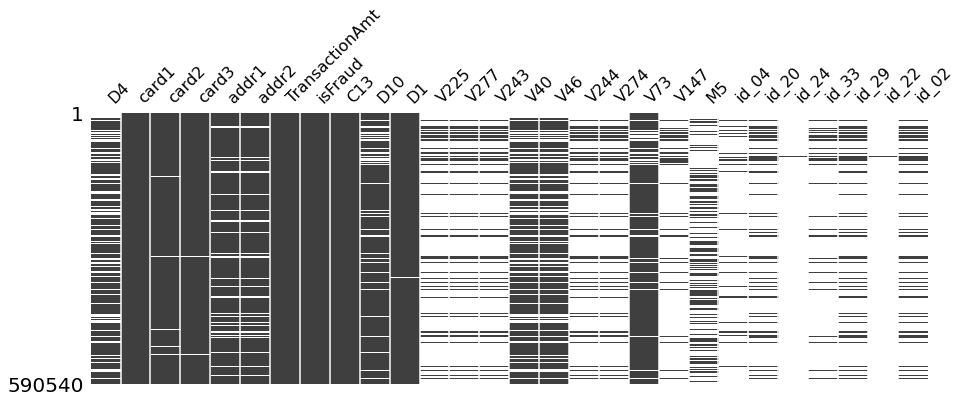

In [7]:
figure, ax = plt.subplots( figsize=(15, 5))
msno.matrix(merged_df, ax=ax, sparkline=False)
plt.show()

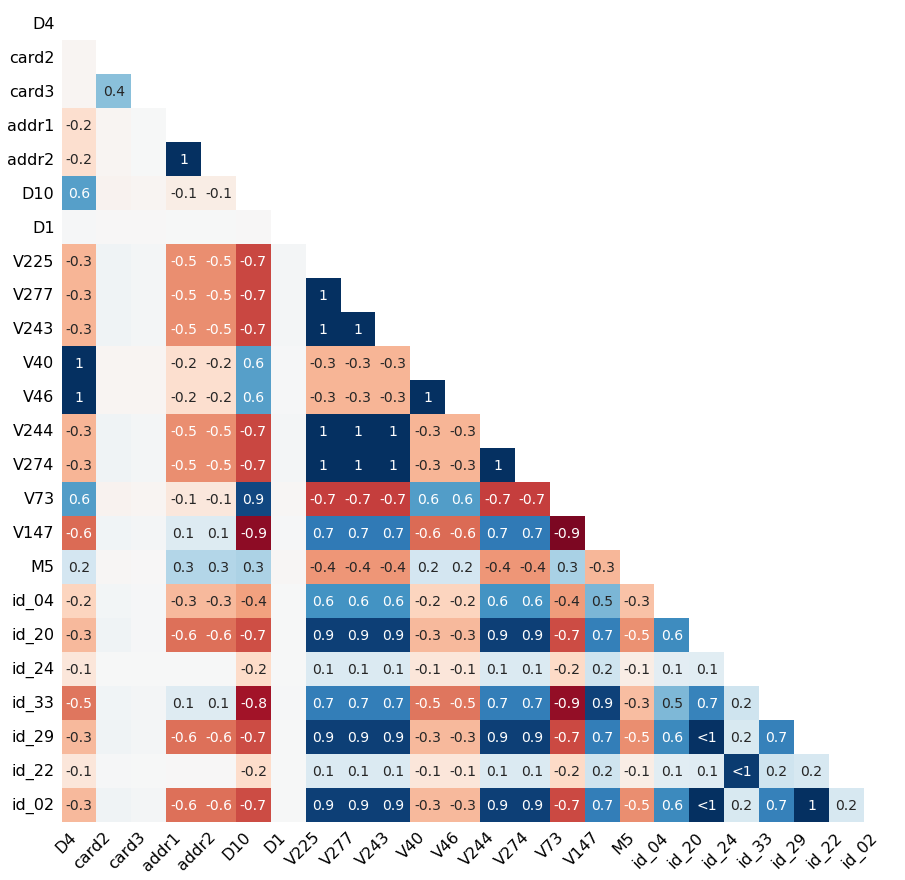

In [8]:
msno.heatmap(merged_df, figsize=(15, 15), cbar=False)
plt.show()

<AxesSubplot:>

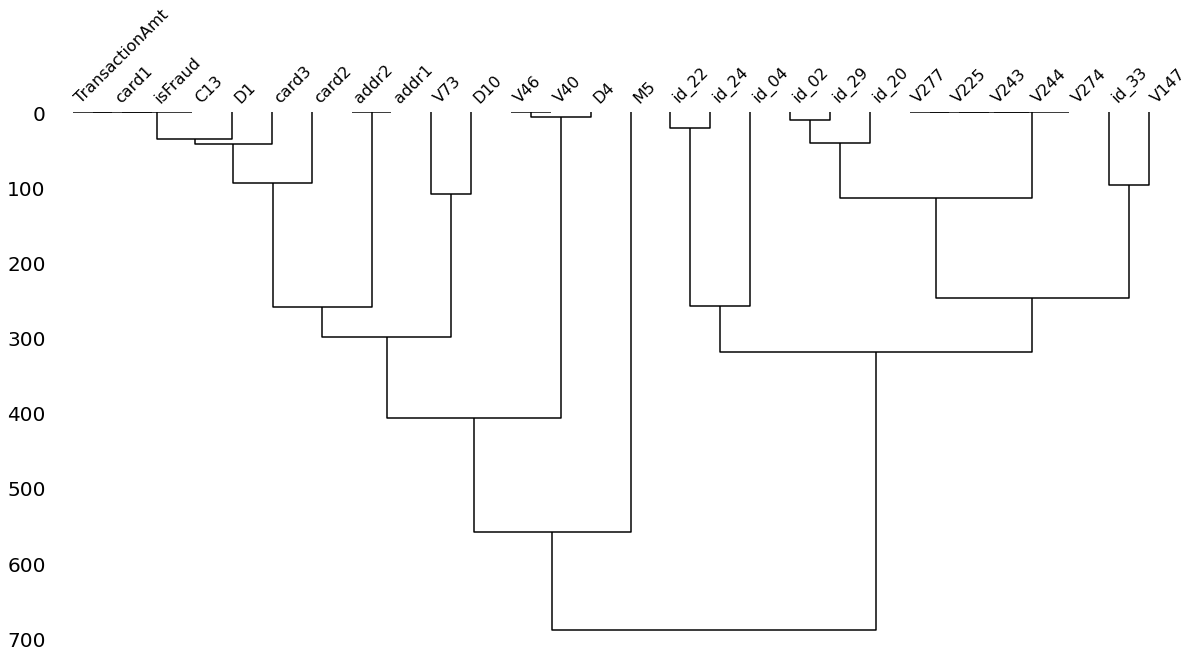

In [9]:
msno.dendrogram(merged_df, figsize=(20, 10))

Отсутствие данных, что интересно, имеет довольно сильную взаимосвязь. По сути, связь отсутствия выше корреляци.

**Анализ дискретности предикторов**

In [10]:
cols_int_check = {}

for col in merged_df.columns:
    current_series = np.array([(x - round(x)) for x in merged_df[col].loc[~merged_df[col].isna()]])
    
    series_data = []

    if current_series.sum() == 0:
        series_data.append(True)
    else:
        series_data.append(False)

    unique_in_series = sorted(np.unique(merged_df[col].loc[~merged_df[col].isna()]))

    series_data.append(len(unique_in_series))

    may_be_category = False

    for idx, value in enumerate(unique_in_series[:-1:]):
        if (value + 1) == unique_in_series[idx + 1]:
            may_be_category = True
        else:
            may_be_category = False

    series_data.append(may_be_category)

    cols_int_check[col] = series_data

In [39]:
pd.DataFrame(cols_int_check, index=['isInt', 'unique values', 'may be category']).T

,isInt,unique values,may be category
D4,True,808,False
card1,True,13553,True
card2,True,500,True
card3,True,114,False
addr1,True,332,False
addr2,True,74,True
TransactionAmt,False,20902,False
isFraud,True,2,True
C13,True,1597,True
D10,True,818,False


Данные, приемущественно, дискретные. Уникальных значений крайне мало. И я решил проверить, а не с категориями ли я имею дело.

Проверку провел самым простым способом. Если в отсортированном массиве уникальных значений следующее от предыдущего отличается на единицу, то у меня появляется основание заподозрить предиктор в категориальности.

Оказалось, что половина датасета может быть категориями. 

**Multivariate imputation**

Для начала примению Multivariate imputation и не буду импутировать предикторы по отдельности. Никакие. 

In [12]:
merged_imputed_df = pd.DataFrame()

if isfile("./data/merged_imputed_df.csv"):
    merged_imputed_df = pd.read_csv(filepath_or_buffer='./data/merged_imputed_df.csv', compression='xz')
else:
    imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
    df_imputed = imputer.fit_transform(merged_df.drop(['isFraud'], axis=1))
    merged_imputed_df = pd.DataFrame(data=df_imputed, columns=merged_df.drop(['isFraud'], axis=1).columns.values).join(merged_df[['isFraud']])
    
    merged_imputed_df.to_csv(path_or_buf='./data/merged_imputed_df.csv', compression='xz')

In [40]:
merged_imputed_df.drop(['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [14]:
for col in cols_int_check:
    if col[0]:
        merged_imputed_df[col].apply(round)

In [15]:
cols_int_check_imputed = {}

for col in merged_imputed_df.columns:
    current_series = np.array([(x - round(x)) for x in merged_imputed_df[col].loc[~merged_imputed_df[col].isna()]])
    
    series_data = []

    if current_series.sum() == 0:
        series_data.append(True)
    else:
        series_data.append(False)

    unique_in_series = sorted(np.unique(merged_imputed_df[col].loc[~merged_imputed_df[col].isna()]))

    series_data.append(len(unique_in_series))

    may_be_category = False

    for idx, value in enumerate(unique_in_series[:-1:]):
        if (value + 1) == unique_in_series[idx + 1]:
            may_be_category = True
        else:
            may_be_category = False

    series_data.append(may_be_category)

    cols_int_check_imputed[col] = series_data

In [17]:
c_tendency_imp = -1.0

if isfile("./data/models/c_tendency_imp.xz"):
    with lzma.open("./data/models/c_tendency_imp.xz", "rb") as m_file:
        c_tendency_imp = pickle.load(m_file)
else:
    c_tendency_imp = hopkins(merged_imputed_df, merged_imputed_df.shape[0])
    
    with lzma.open("./data/models/c_tendency_imp.xz", "wb") as m_file:
        pickle.dump(c_tendency_imp, m_file)

print("Clustering tendency is {:.4f}.".format(c_tendency_imp))

Clustering tendency is 0.0208.


In [35]:
summary_cols_info = {}

for col in merged_imputed_cols_info_df:
    summary_data = []
    for i in range(3):
        summary_data.append(cols_int_check[col][i])
        summary_data.append(cols_int_check_imputed[col][i])
    
    summary_cols_info[col] = summary_data

In [38]:
pd.DataFrame(summary_cols_info, index=['isInt', 'isInt imp', 'unique values', 'unique values imp', 'may be category', 'may be category imp']).T

,isInt,isInt imp,unique values,unique values imp,may be category,may be category imp
D4,True,False,808,52026,False,False
card1,True,True,13553,13553,True,True
card2,True,False,500,3902,True,True
card3,True,False,114,386,False,False
addr1,True,False,332,27565,False,False
addr2,True,False,74,4879,True,True
TransactionAmt,False,False,20902,20902,False,False
C13,True,True,1597,1597,True,True
D10,True,False,818,22234,False,False
D1,True,False,641,1420,True,True


Вобще ерунда получилась. Те предикторы, за которые я точно знаю что они категориальны, вобще ни на что не похожи.

Попробую теперь имутировать категориальные предикторы отдельно.